In [11]:
%pip install -r ../requirements-examples.txt --quiet

Note: you may need to restart the kernel to use updated packages.


# LIME explanations

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [1]:
from trustyai.utils import TestModels

center = 10.0
epsilon = 2.0

model = TestModels.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [2]:
from trustyai.model import output

decision = "inside"
goal = [output(name=decision, dtype="bool", value=True, score=0.0)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [3]:
import random
from trustyai.model import feature

features = [feature(name=f"x{i+1}", dtype="number", value=random.random()*10.0) for i in range(3)]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [4]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 4.6906326936080145
Feature x2 has value 1.3221951955309186
Feature x3 has value 4.332170525737446

Features sum is 10.344998414876379


We execute the model on the generated input and collect the output

In [5]:
from org.kie.trustyai.explainability.model import PredictionInput, PredictionOutput

goals = model.predictAsync([PredictionInput(features)]).get()
goals[0].outputs.get(0).toString()

'Output{value=true, type=boolean, score=1.655001585123621, name='inside'}'

We can now instantiate the **explainer** itself.


In [6]:
from trustyai.explainers import LimeExplainer

explainer = LimeExplainer(samples=10)

We generate the **explanation** as a _dict : decision --> saliency_.


In [7]:
explanation = explainer.explain(inputs=features, outputs=goals[0].outputs, model=model)

[ForkJoinPool.commonPool-worker-2] WARN org.kie.trustyai.explainability.local.lime.LimeExplainer - Using a hardly separable dataset for output 'inside' of type 'boolean' with value 'true' ({1.0=38})


In [8]:
explanation.as_dataframe()['inside']

,Feature,Value,Saliency,Confidence
0,x1,4.690633,0.425266,0.0
1,x2,1.322195,0.352752,0.0
2,x3,4.332171,0.513838,0.0


We inspect the saliency scores assigned by LIME to each feature

We generate the saliency graph with the builtin method `plot(decision)`:

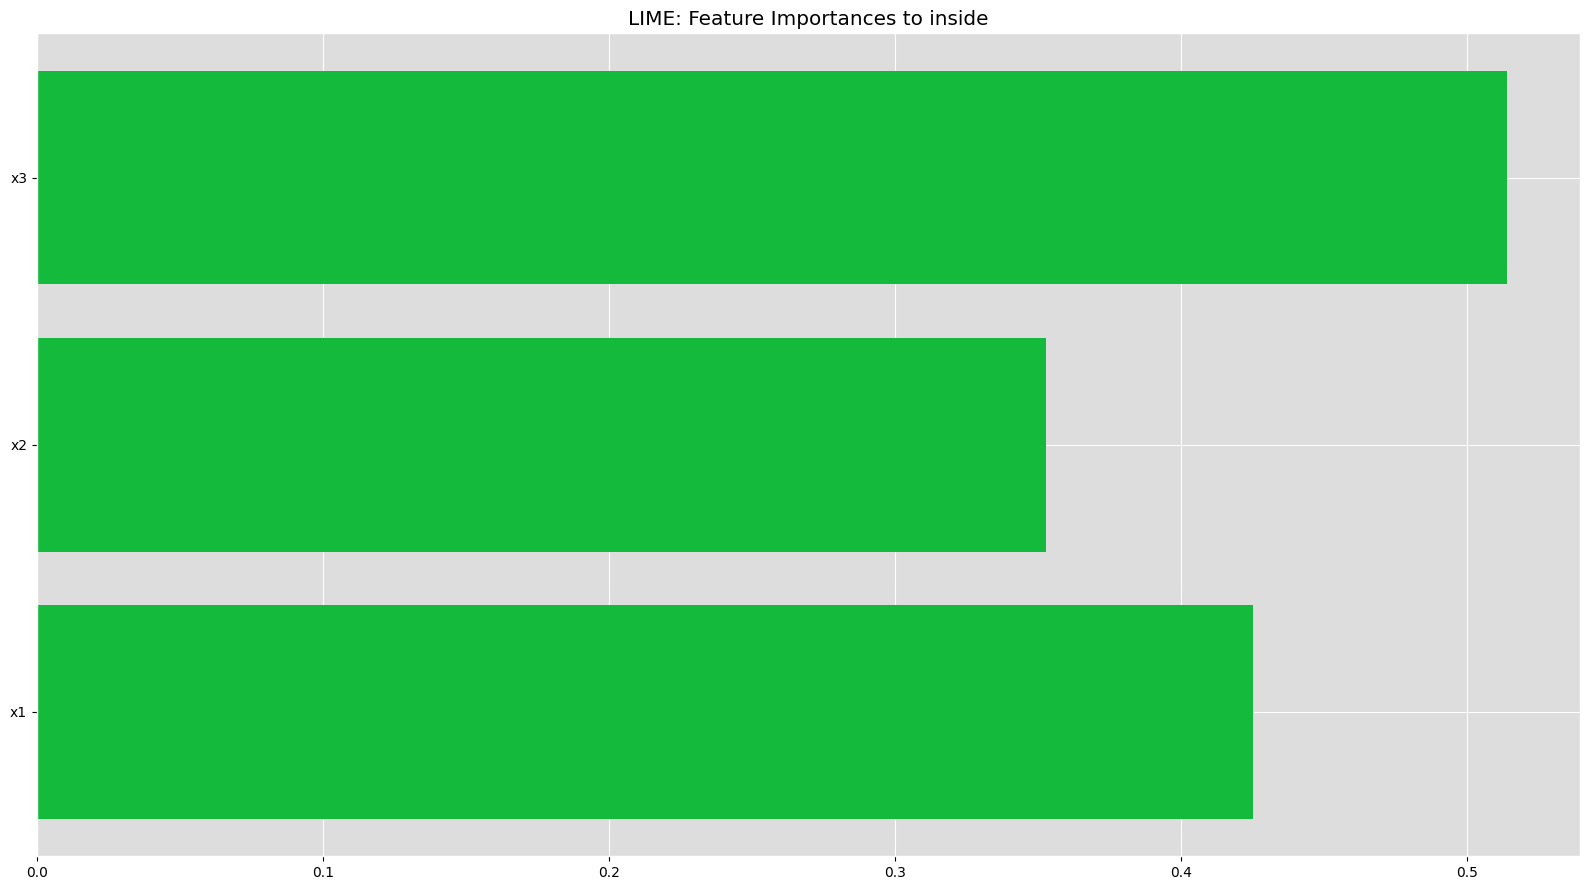

In [9]:
explanation.plot(decision)

## Using Python models



We will now show how to use a custom Python model with TrustyAI LIME implementation.

The model will be an XGBoost one trained with the `credit-bias` dataset.

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [12]:
import joblib

xg_model = joblib.load("models/credit-bias-xgboost.joblib")
print(xg_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

Let's create and test a sample datapoint:

In [13]:
import pandas as pd

feature_values = {
        "NewCreditCustomer": False,
        "Amount": 2125.0,
        "Interest": 20.97,
        "LoanDuration": 60.0,
        "Education": 4.0,
        "NrOfDependants": 0.0,
        "EmploymentDurationCurrentEmployer": 6.0,
        "IncomeFromPrincipalEmployer": 0.0,
        "IncomeFromPension": 301.0,
        "IncomeFromFamilyAllowance": 0.0,
        "IncomeFromSocialWelfare": 53.0,
        "IncomeFromLeavePay": 0.0,
        "IncomeFromChildSupport": 0.0,
        "IncomeOther": 0.0,
        "ExistingLiabilities": 8.0,
        "RefinanceLiabilities": 6.0,
        "DebtToIncome": 26.29,
        "FreeCash": 10.92,
        "CreditScoreEeMini": 1000.0,
        "NoOfPreviousLoansBeforeLoan": 1.0,
        "AmountOfPreviousLoansBeforeLoan": 500.0,
        "PreviousRepaymentsBeforeLoan": 590.95,
        "PreviousEarlyRepaymentsBefoleLoan": 0.0,
        "PreviousEarlyRepaymentsCountBeforeLoan": 0.0,
        "Council_house": False,
        "Homeless": False,
        "Joint_ownership": False,
        "Joint_tenant": False,
        "Living_with_parents": False,
        "Mortgage": False,
        "Other": False,
        "Owner": False,
        "Owner_with_encumbrance": True,
        "Tenant": True,
        "Entrepreneur": False,
        "Fully": False,
        "Partially": False,
        "Retiree": True,
        "Self_employed": False
}

feature_df = pd.DataFrame([feature_values])
feature_df

,NewCreditCustomer,Amount,Interest,LoanDuration,Education,NrOfDependants,EmploymentDurationCurrentEmployer,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,...,Mortgage,Other,Owner,Owner_with_encumbrance,Tenant,Entrepreneur,Fully,Partially,Retiree,Self_employed
0,False,2125.0,20.97,60.0,4.0,0.0,6.0,0.0,301.0,0.0,...,False,False,False,True,True,False,False,False,True,False


We can see that this application will be rejected with a probability of $\sim77\%$:

In [14]:
import numpy as np

print(xg_model.predict_proba(feature_df))
print(f"Paid loan is predicted as: {xg_model.predict(feature_df)}")

[[0.7835957  0.21640435]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI. Since our model outputs a Numpy array, we need to specify the column names of the output. Additionally, we must make sure our model's outputs are of shape `[n_inputs, n_outputs]`, which we can do by wrapping the model output into a DataFrame:

Once the prediction method is created, we wrap in a `Model` class.

This class takes care of all the JVM's asynchronous plumbing for us.

In [15]:
from trustyai.model import Model

model = Model(xg_model.predict, output_names=['PaidLoan'])

We can confirm now, with the newly created `PredictionProvider` model that this input will lead to a `false` `PaidLoan` prediction:

In [16]:
output = model(feature_df)
output

array([False])

We execute the LIME explainer on the XGBoost model and prediction

In [17]:
from trustyai.explainers import LimeExplainer

explainer = LimeExplainer(samples=100, perturbations=2, seed=23, normalise_weights=False)
explanation = explainer.explain(inputs=feature_df, outputs=output, model=model)

[main] INFO org.apache.arrow.memory.BaseAllocator - Debug mode disabled.
[main] INFO org.apache.arrow.memory.DefaultAllocationManagerOption - allocation manager type not specified, using netty as the default type
[main] INFO org.apache.arrow.memory.CheckAllocator - Using DefaultAllocationManager at memory/DefaultAllocationManagerFactory.class
[ForkJoinPool.commonPool-worker-2] WARN org.kie.trustyai.explainability.local.lime.LimeExplainer - Using a hardly separable dataset for output 'PaidLoan' of type 'boolean' with value '0' ({0.0=398})


We output the top 2 most important features for the prediction outcome

In [18]:
explanation.as_dataframe()['PaidLoan'].sort_values(by="Saliency")

,Feature,Value,Saliency,Confidence
0,Fully,0.0,-9.039604e-10,0.0
2,Owner,0.0,-5.065592e-10,0.0
5,Homeless,0.0,-3.075532e-10,0.0
1,IncomeFromChildSupport,0.0,2.827385e-10,0.0
4,LoanDuration,60.0,5.266562e-10,0.0
3,Self_employed,0.0,6.746940e-10,0.0


In [19]:
explanation.as_dataframe()['PaidLoan']

,Feature,Value,Saliency,Confidence
0,Fully,0.0,-9.039604e-10,0.0
1,IncomeFromChildSupport,0.0,2.827385e-10,0.0
2,Owner,0.0,-5.065592e-10,0.0
3,Self_employed,0.0,6.746940e-10,0.0
4,LoanDuration,60.0,5.266562e-10,0.0
5,Homeless,0.0,-3.075532e-10,0.0


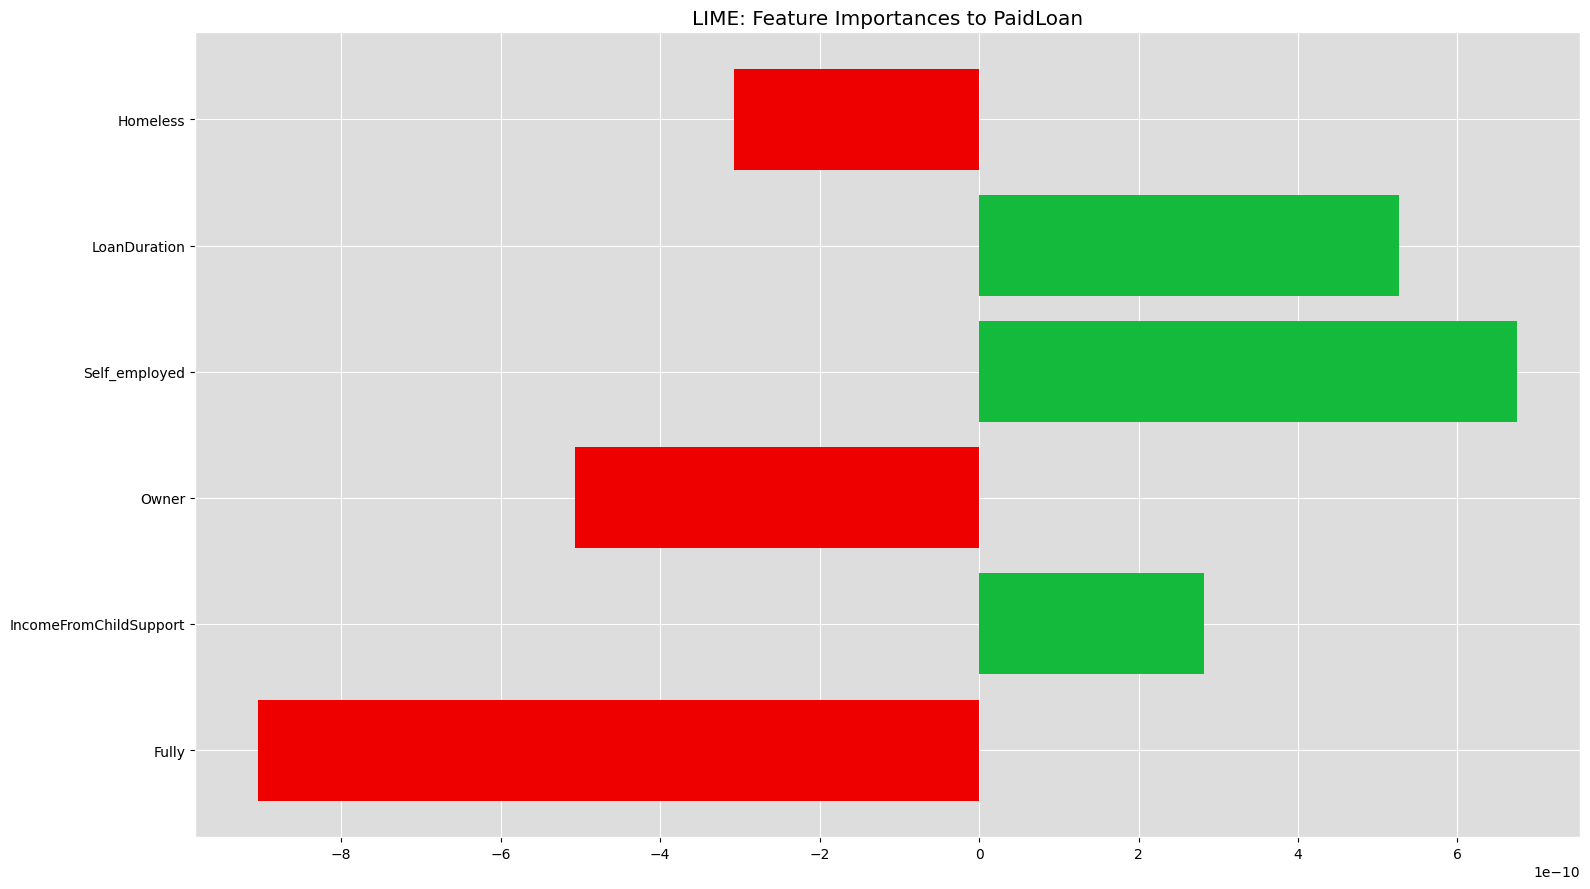

In [20]:
explanation.plot('PaidLoan')